# Figures for Physical Insights from the Multidecadal Prediction of North Atlantic Sea Surface Temperature Variability Using Explainable Neural Networks
Glenn Liu, Peidong Wang, Young-Oh Kwon

This notebook contains code used to generate the main figures (or figure components) of the manuscript.
To generate the figures, check to make sure the required files described in the **Input** section for each figure are present.

### Table of Contents
1. Figure 1: Example Predictors and Target for FNN
2. Figure 2: Mean Accuracy by Leadtime
3. Figure 3: Relevance Composites for correct NASST+ predictions
4. Figure 4: Class Prediction Count by Year for HadISST


In [1]:
# Import Packages

import sys
import numpy as np
import os
import time
import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset,Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import copy
import xarray as xr

In [27]:
# User Edits

# Other paths
datpath          = "../../results_manuscript/"

# Custom Module Packages
amvpath          = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/"
pytorch_lrp_path = "/Users/gliu/Downloads/02_Research/03_Code/github/Pytorch-LRP-master/"

In [28]:
# Import custom packages and other modules

# Import general utilities from amv module
sys.path.append(amvpath)
import proc,viz

# Import packages specific to predict_amv
cwd = os.getcwd()
sys.path.append(cwd+"/../")
import predict_amv_params as pparams
import train_cesm_params as train_cesm_params
import amv_dataloader as dl
import amvmod as am

# LRP Methods
sys.path.append(pytorch_lrp_path)
from innvestigator import InnvestigateModel

In [53]:
%load_ext autoreload
%autoreload 2
# Cell Magic for reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Load some additional variables
bbox         = pparams.bbox
class_colors = pparams.class_colors


## Figure 1: Example Predictors and Target

The figure was assembeled in Inkscape. This notebook generates an example of the predictors and AMV Index used for the prediction

Inputs:
 - Predictors processed by \[prep_data_byvariable.py\], located in [datpath]/Predictors/
 - Targets processed by \[prepare_regional_targets.py\], located in [datpath]/Targets/

Contents:
1. User Edits
2. Load in data (target and predictors)
3. Visualize Index (Prediction Target)
4. Visualize Predictors

In [31]:
# User Edits
varnames     = ["SST","SLP","SSS","SSH"]
expdir       = "FNN4_128_SingleVar_PaperRun" # Experiment Directory Name
datpath_pred = "%sPredictors/" % datpath
datpath_targ = "%sTargets/" % datpath
eparams      = train_cesm_params.train_params_all[expdir]
leads        = np.arange(0,26,1)

# Load some experiment parameters
norm         = eparams['norm']
ens          = eparams['ens']

In [32]:
# Load target and data
# --------------------
# Load data + target
# Load predictor and labels, lat/lon, cut region
target         = dl.load_target_cesm(detrend=eparams['detrend'],region=eparams['region'],norm=norm,datpath=datpath_targ)
data,lat,lon   = dl.load_data_cesm(varnames,eparams['bbox'],detrend=eparams['detrend'],return_latlon=True,datpath=datpath_pred)

# Make a mask and apply
limask                         = dl.load_limask(bbox=eparams['bbox'])
data                           = data * limask[None,None,None,:,:]  # NaN Points to Zero

# Normalize data
nchannels = data.shape[0]
# *** Note, doing this for each channel, but in reality, need to do for all channels
for ch in range(nchannels):
    std_var = np.nanstd(data[ch,...])
    mu_var = np.nanmean(data[ch,...])
    data[ch,...] = (data[ch,...] - mu_var)/std_var

# Change nan points to zero
data[np.isnan(data)] = 0 

# Determine Target Classes
# ------------------------
# Set exact threshold value
std1         = target.std(1).mean() * eparams['thresholds'][1] # Multiple stdev by threshold value 
if eparams['quantile'] is False:
    thresholds_in = [-std1,std1]
else:
    thresholds_in = eparams['thresholds']

# Classify AMV Events
target_class = am.make_classes(target.flatten()[:,None],thresholds_in,exact_value=True,reverse=True,quantiles=eparams['quantile'])
target_class = target_class.reshape(target.shape)

Class 2 Threshold is y <= -0.37 
Class 1 Threshold is -0.37 < y <= 0.37 
Class 0 Threshold is y > 0.37 


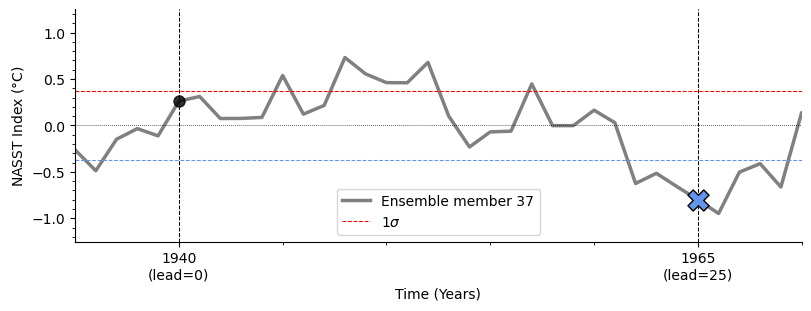

In [33]:
# Visualize the NASST Index

e       = 36

lead0   = 1940
N       = 25

startyr = 1920
yrs     = np.arange(startyr,startyr+target.shape[1])

# Get lead0 and leadN indices
ipred   = np.where(yrs==lead0)[0][0]
ilabel  = ipred+N
lead1   = lead0+N
xtk     = [lead0,lead1]
xtklabs = (str(lead0) + "\n(lead=0)",str(lead1)+"\n(lead=%i)"%N) 

fig,ax= plt.subplots(1,1,figsize=(8,3),constrained_layout=True)
ax.plot(yrs,target[e,:],c="gray",label="Ensemble member %02i" % (e+1),lw=2.5)

ax.spines[['right', 'top']].set_visible(False)

ax.axhline([0],ls="dotted",color="k",lw=0.55)
ax.axhline([-std1],ls="dashed",color="cornflowerblue",lw=0.75,label="")
ax.axhline([std1],ls="dashed",color="red",lw=0.75,label="1$\sigma$")
ax.legend(loc="lower center")
ax.minorticks_on()
ax.set_ylim([-1.25,1.25])
ax.set_xlim([1935,1970])
ax.set_ylabel("NASST Index ($\degree$C)")
ax.set_xlabel("Time (Years)")

# Plot sample leadtimes for prediction
ax.set_xticks(xtk,labels=xtklabs) # Label lead 0 and lead N
ax.scatter(lead0,target[e,ipred],marker=".",color="k",label="",
        s=255,edgecolors="k",zorder=3,alpha=0.8) # Plot lead0
ax.axvline([lead0],color="k",ls="dashed",lw=0.75,zorder=1)
ax.scatter(lead1,target[e,ilabel],marker="X",color="cornflowerblue",label="",
        s=230,edgecolors="k",zorder=3) # Plot lead0
ax.axvline([lead1],color="k",ls="dashed",lw=0.75,zorder=1)
     
#savename = "%sNASST_Prediction_Example_Ens%i_Start%04i_lead%02i.svg" % (figpath,e+1,lead0,N)
#plt.savefig(savename,transparent=True,dpi=300)

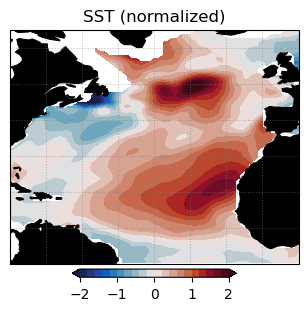

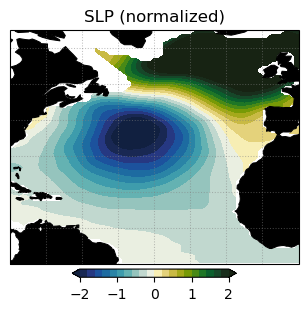

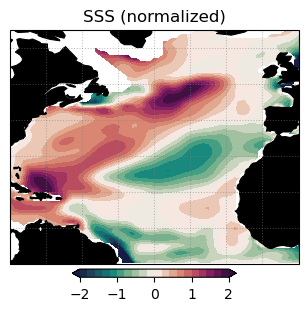

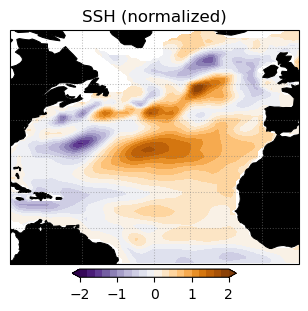

In [34]:
# Visualize Predictor values


consistent_mask = np.sum(data,(0,1,2)) == 0

use_contour = True
nvars = len(varnames)
vlims = [-2,2]
vcmap = ["cmo.balance","cmo.delta","cmo.curl","PuOr_r"]
varunits = [("normalized"),] * nvars
for v in range(nvars):
    
    fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(0)},
                          constrained_layout=True,figsize=(4,3))
    
    ax.set_extent(bbox)
    plotdata = data[v,e,ipred,:,:].copy() * limask
    if use_contour:
        pcm = ax.contourf(lon,lat,plotdata,levels=np.arange(-2.0,2.2,0.2),cmap=vcmap[v],extend="both")
    else:
        pcm = ax.pcolormesh(lon,lat,plotdata,vmin=vlims[0],vmax=vlims[1],cmap=vcmap[v])
    viz.add_coast_grid(ax=ax,bbox=bbox,blabels=[0,0,0,0],fill_color="k")
    ax.set_title("%s (normalized)" % (varnames[v]))
    cb = fig.colorbar(pcm,ax=ax,orientation='horizontal',fraction=0.035,pad=0.02,
                      ticks=[-2,-1,0,1,2])
    
    #cb.ax.set_yticklabels(['< -1', '0', '> 1'])
    #cb.set_label("%s (%s)" % (varnames[v],varunits[v]))
    
    # savename = "%sNASST_Prediction_Example_Ens%i_Start%04i_predictor%s.svg" % (figpath,e+1,lead0,varnames[v])
    # plt.savefig(savename,transparent=True,dpi=300)

## Figure 2: Mean Accuracy by Leadtime

For the forced and unforced experiments, plot the mean accuracy by leadtime for NNs trained by each predictor. Compare the results with the persistence baseline and random chance. 

Inputs: 
 - The test accuracies from the NN experiments was computed from \[compute_test_metrics.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 - Persistence baselines for CESM computed from \[calculate_persistence_baseline.py\], "[datpath]/[expdir]/Baselines/"
 
 
Contents:
1. User Edits
2. Load FNN Accuracies and Baselines
3. Make Plot

*Moved from working script \[viz_acc_bypredictor.py\] on 2023.09.13*

In [35]:
# User Edits
# ----------------------------------

# Labels and Experiments to compare
expdirs         = ("FNN4_128_Singlevar_PaperRun","FNN4_128_Singlevar_PaperRun_detrended")
expdirs_long    = ("Forced","Unforced")

# Other Settings
chance_baseline = (0.33,)*3

# Variables and other settings
varnames        = ('SST', 'SSS', 'SLP', 'SSH')
varcolors       = ("r","violet","gold","dodgerblue",)
varmarker       = ("o","d","x","^")
classes_new     = ("NASST+","Neutral","NASST-")
leads           = np.arange(0,26,1)

In [38]:
## Load Results
# ----------------------------------

# Load the FNN Accuracy By Predictor
# ----------------------------------
alloutputs = []
for expdir in expdirs:
    output_byvar = []
    for v in varnames:
        fn              = "%s%s/Metrics/Test_Metrics/Test_Metrics_CESM1_%s_evensample0_accuracy_predictions.npz" % (datpath,expdir,v)
        npz             = np.load(fn,allow_pickle=True)
        expdict         = proc.npz_to_dict(npz)
        output_byvar.append(expdict)
    alloutputs.append(output_byvar)

# Load the Persistence Baseline
# ----------------------------------
persaccclass = []
persacctotal = []
persleads   = []
for detrend in [False,True]:
    fn_baseline      = "%s/Baselines/persistence_baseline_CESM1_NAT_detrend%i_quantile0_nsamplesNone_repeat1.npz" % (datpath,detrend,)
    ldp              = np.load(fn_baseline)
    pers_class_acc   = ldp['acc_by_class']
    pers_total_acc   = ldp['total_acc']
    pers_leads       = ldp['leads']
    persaccclass.append(pers_class_acc)
    persacctotal.append(pers_total_acc)
    persleads.append(pers_leads)

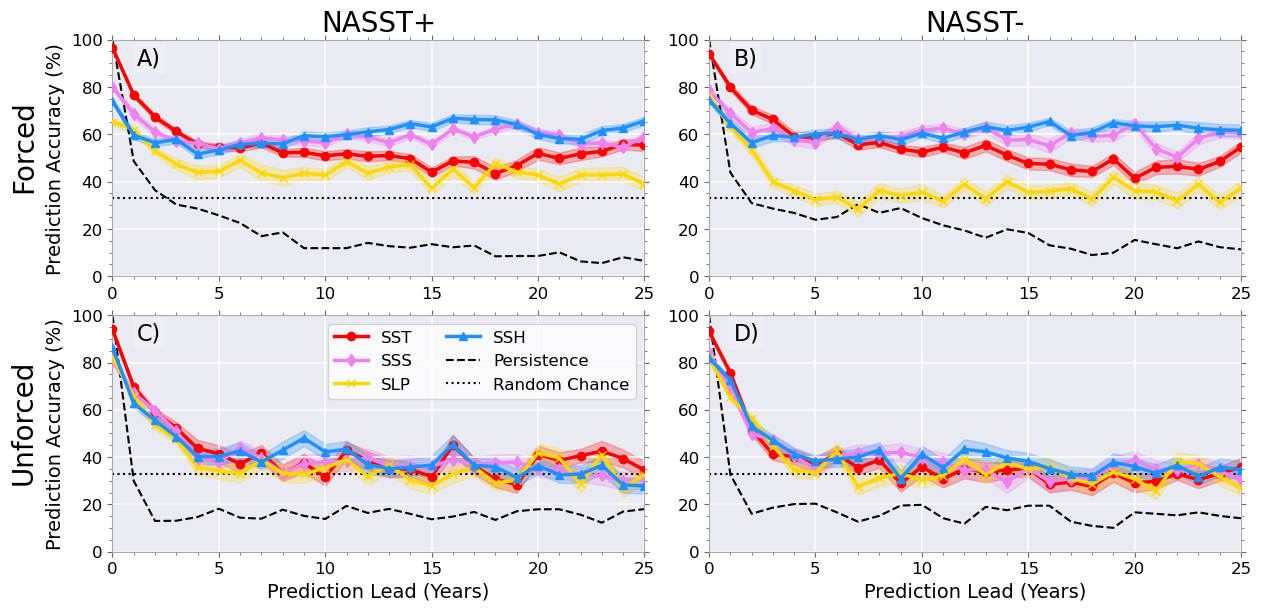

In [39]:
# Make Fig 2
# ----------------------------------

# Set Color Mode
darkmode = False
if darkmode == True:
    plt.style.use('dark_background')
    dfcol = "w"
else:
    plt.style.use('default')
    dfcol = "k"

# Get some needed information variables
nvars        = len(varnames)

# Toggles and ticks
plotclasses  = [0,2]     # Just plot positive/negative
expnums      = [0,1]     # Which Experiments to Plot
detrends     = [0,1]     # Whether or not it was detrended
leadticks    = np.arange(0,26,5)
legend_sp    = 2         # Subplot where legend is included
ytks         = np.arange(0,1.2,.2)

# Error Bars
plotstderr   = True  # If True, plot standard error (95%), otherwise plot 1-stdev
alpha        = 0.25  # Alpha of error bars

# Initialize figures
fig,axs =  plt.subplots(2,2,constrained_layout=True,figsize=(12.5,6))
it = 0
for iplot,ex in enumerate(expnums):
    
    # Get the axes row
    axs_row = axs[iplot,:]
    
    # Unpack the data
    totalacc = np.array([alloutputs[ex][v]['total_acc'] for v in range(nvars)])
    classacc = np.array([alloutputs[ex][v]['class_acc'] for v in range(nvars)])
    ypred    = np.array([alloutputs[ex][v]['predictions'] for v in range(nvars)])
    ylabs    = np.array([alloutputs[ex][v]['targets'] for v in range(nvars)])
    
    # Indicate detrending
    exp_dt = detrends[ex]
    
    for rowid,c in enumerate(plotclasses):
        
        ax = axs_row[rowid]
        
        # Initialize plot
        viz.label_sp(it,ax=ax,fig=fig,fontsize=pparams.fsz_splbl,
                     alpha=0.2,x=0.02)
        
        # Set Ticks/limits
        ax.set_xlim([0,24])
        ax.set_xticks(leadticks,fontsize=pparams.fsz_ticks)
        ax.set_ylim([0,1])
        ax.set_yticks(ytks,fontsize=pparams.fsz_ticks)
        ax.set_yticklabels((ytks*100).astype(int),)
        ax = viz.add_ticks(ax,facecolor="#eaeaf2",grid_lw=1.5,grid_col="w",grid_ls="solid",
                            spinecolor="darkgray",tickcolor="dimgray",
                            ticklabelcolor="k",fontsize=pparams.fsz_ticks)
        
        # Add Class Labels
        if iplot == 0:
            ax.set_title("%s" %(classes_new[c]),fontsize=pparams.fsz_title,)
        
        # Loop for each predictor
        for i in range(nvars):
            
            # Compute Mean and 2*stderr (or sigma)
            mu       = classacc[i,:,:,c].mean(0)
            if plotstderr:
                sigma = 2*classacc[i,:,:,c].std(0) / np.sqrt(classacc.shape[1])
            else:
                sigma = np.array(plotacc).std(0)
            
            # Plot mean and bounds
            ax.plot(leads,mu,color=varcolors[i],marker=varmarker[i],alpha=1.0,lw=2.5,label=varnames[i],zorder=3)
            ax.fill_between(leads,mu-sigma,mu+sigma,alpha=alpha,color=varcolors[i],zorder=1)
        
        # Plot the persistence and chance baselines
        ax.plot(leads,persaccclass[exp_dt][:,c],color=dfcol,label="Persistence",ls="dashed")
        ax.axhline(chance_baseline[c],color=dfcol,label="Random Chance",ls="dotted")
        
        # Additional Labeling (y-axis and experiment)
        if c == 0:
            ax.set_ylabel("Prediction Accuracy (%)",fontsize=pparams.fsz_axlbl,) # Label Y-axis for first column
            ax.text(-0.14, 0.55,expdirs_long[ex], va='bottom', ha='center',rotation='vertical',
                    rotation_mode='anchor',transform=ax.transAxes,fontsize=pparams.fsz_title)
        
        # Label x-axis and set legend
        if (ex == 1):
            ax.set_xlabel("Prediction Lead (Years)",fontsize=pparams.fsz_axlbl,) # Label Y-axis for first column
        if it == legend_sp:
            ax.legend(ncol=2,fontsize=pparams.fsz_legend)
        it += 1

# plt.savefig("%sPredictor_Intercomparison_byclass_detredn%i_plotmax%i_%s_OutlineVer_stderr%i.png"% (figpath,detrend,plotmax,expdirs[expnum],plotstderr),
#             dpi=200,bbox_inches="tight",transparent=False)

## Figure 3: Relevance Composites for correct NASST+ predictions

Creates relevance composites for correct class predictions (NASST+,Neutral,NASST-) of the top 50 performing networks.

Inputs
 - Relevance and predictor composites computed from \[compute_test_metrics.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 
Contents
1. User Edits
2. Load in Computed Relevances + Predictors Composites
3. Composite Top N Performing Networks
4. Make Figure

*Moved from working script \[viz_LRP_predictor.py\] on 2023.09.13*

In [40]:
# Figure 3: User Edits
# --------------------------

# Data and variable settings
varnames       = ("SST","SSH","SSS","SLP") 
varnames_plot  = ("SST","SSH","SSS","SLP")
expdir         = "FNN4_128_SingleVar_PaperRun"
eparams        = train_cesm_params.train_params_all[expdir]
classes        = classes_new
datpath        = "../../results_manuscript/"
metrics_dir    = "%s%s/Metrics/Test_Metrics/" % (datpath,expdir)
print(metrics_dir)

# Compositing options
nmodels        = 100 # Specify manually how many networks to load for the analysis
topN           = 50 # Top N networks to include in composite

# Plotting Options
proj           = ccrs.PlateCarree()

# Toggles
debug          = False

../../results_manuscript/FNN4_128_SingleVar_PaperRun/Metrics/Test_Metrics/


In [41]:
# Load the Relevance and Predictor Composites
# -----------------------------
nvars       = len(varnames)
nleads      = len(leads)
#metrics_dir = "%s%s/Metrics/Test_Metrics/" % (datpath,expdir)
pcomps   = []
rcomps   = []
ds_all   = []
acc_dict = []
for v in range(nvars):
    # Load the composites
    varname = varnames[v]
    ncname = "%sTest_Metrics_CESM1_%s_evensample0_relevance_maps.nc" % (metrics_dir,varname)
    ds     = xr.open_dataset(ncname)
    rcomps.append(ds['relevance_composites'].values)
    pcomps.append(ds['predictor_composites'].values)
    
    # Load the accuracies
    ldname  = "%sTest_Metrics_CESM1_%s_evensample0_accuracy_predictions.npz" % (metrics_dir,varname)
    npz     = np.load(ldname,allow_pickle=True)
    expdict = proc.npz_to_dict(npz)
    acc_dict.append(expdict)

nleads,nruns,nclasses,nlat,nlon=rcomps[v].shape
lon = ds.lon.values
lat = ds.lat.values

In [42]:
# Composite top N performing networks for each class
# --------------------------------------------------
class_accs  = [acc_dict[v]['class_acc'] for v in range(nvars)]
rcomps_topN = np.zeros((nvars,nleads,nclasses,nlat,nlon))

for v in range(nvars):
    for l in tqdm.tqdm(range(nleads)):
        for c in range(nclasses):
            # Get ranking of models by test accuracy
            acc_list = class_accs[v][:,l,c] # [runs]
            id_hi2lo  = np.argsort(acc_list)[::-1] # Reverse to get largest value first
            id_topN   = id_hi2lo[:topN]
            
            # Make composite 
            rcomp_in  = rcomps[v][l,id_topN,c,:,:] # [runs x lat x lon]
            rcomps_topN[v,l,c,:,:] = rcomp_in.mean(0) # Mean along run dimension

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1251.40it/s]


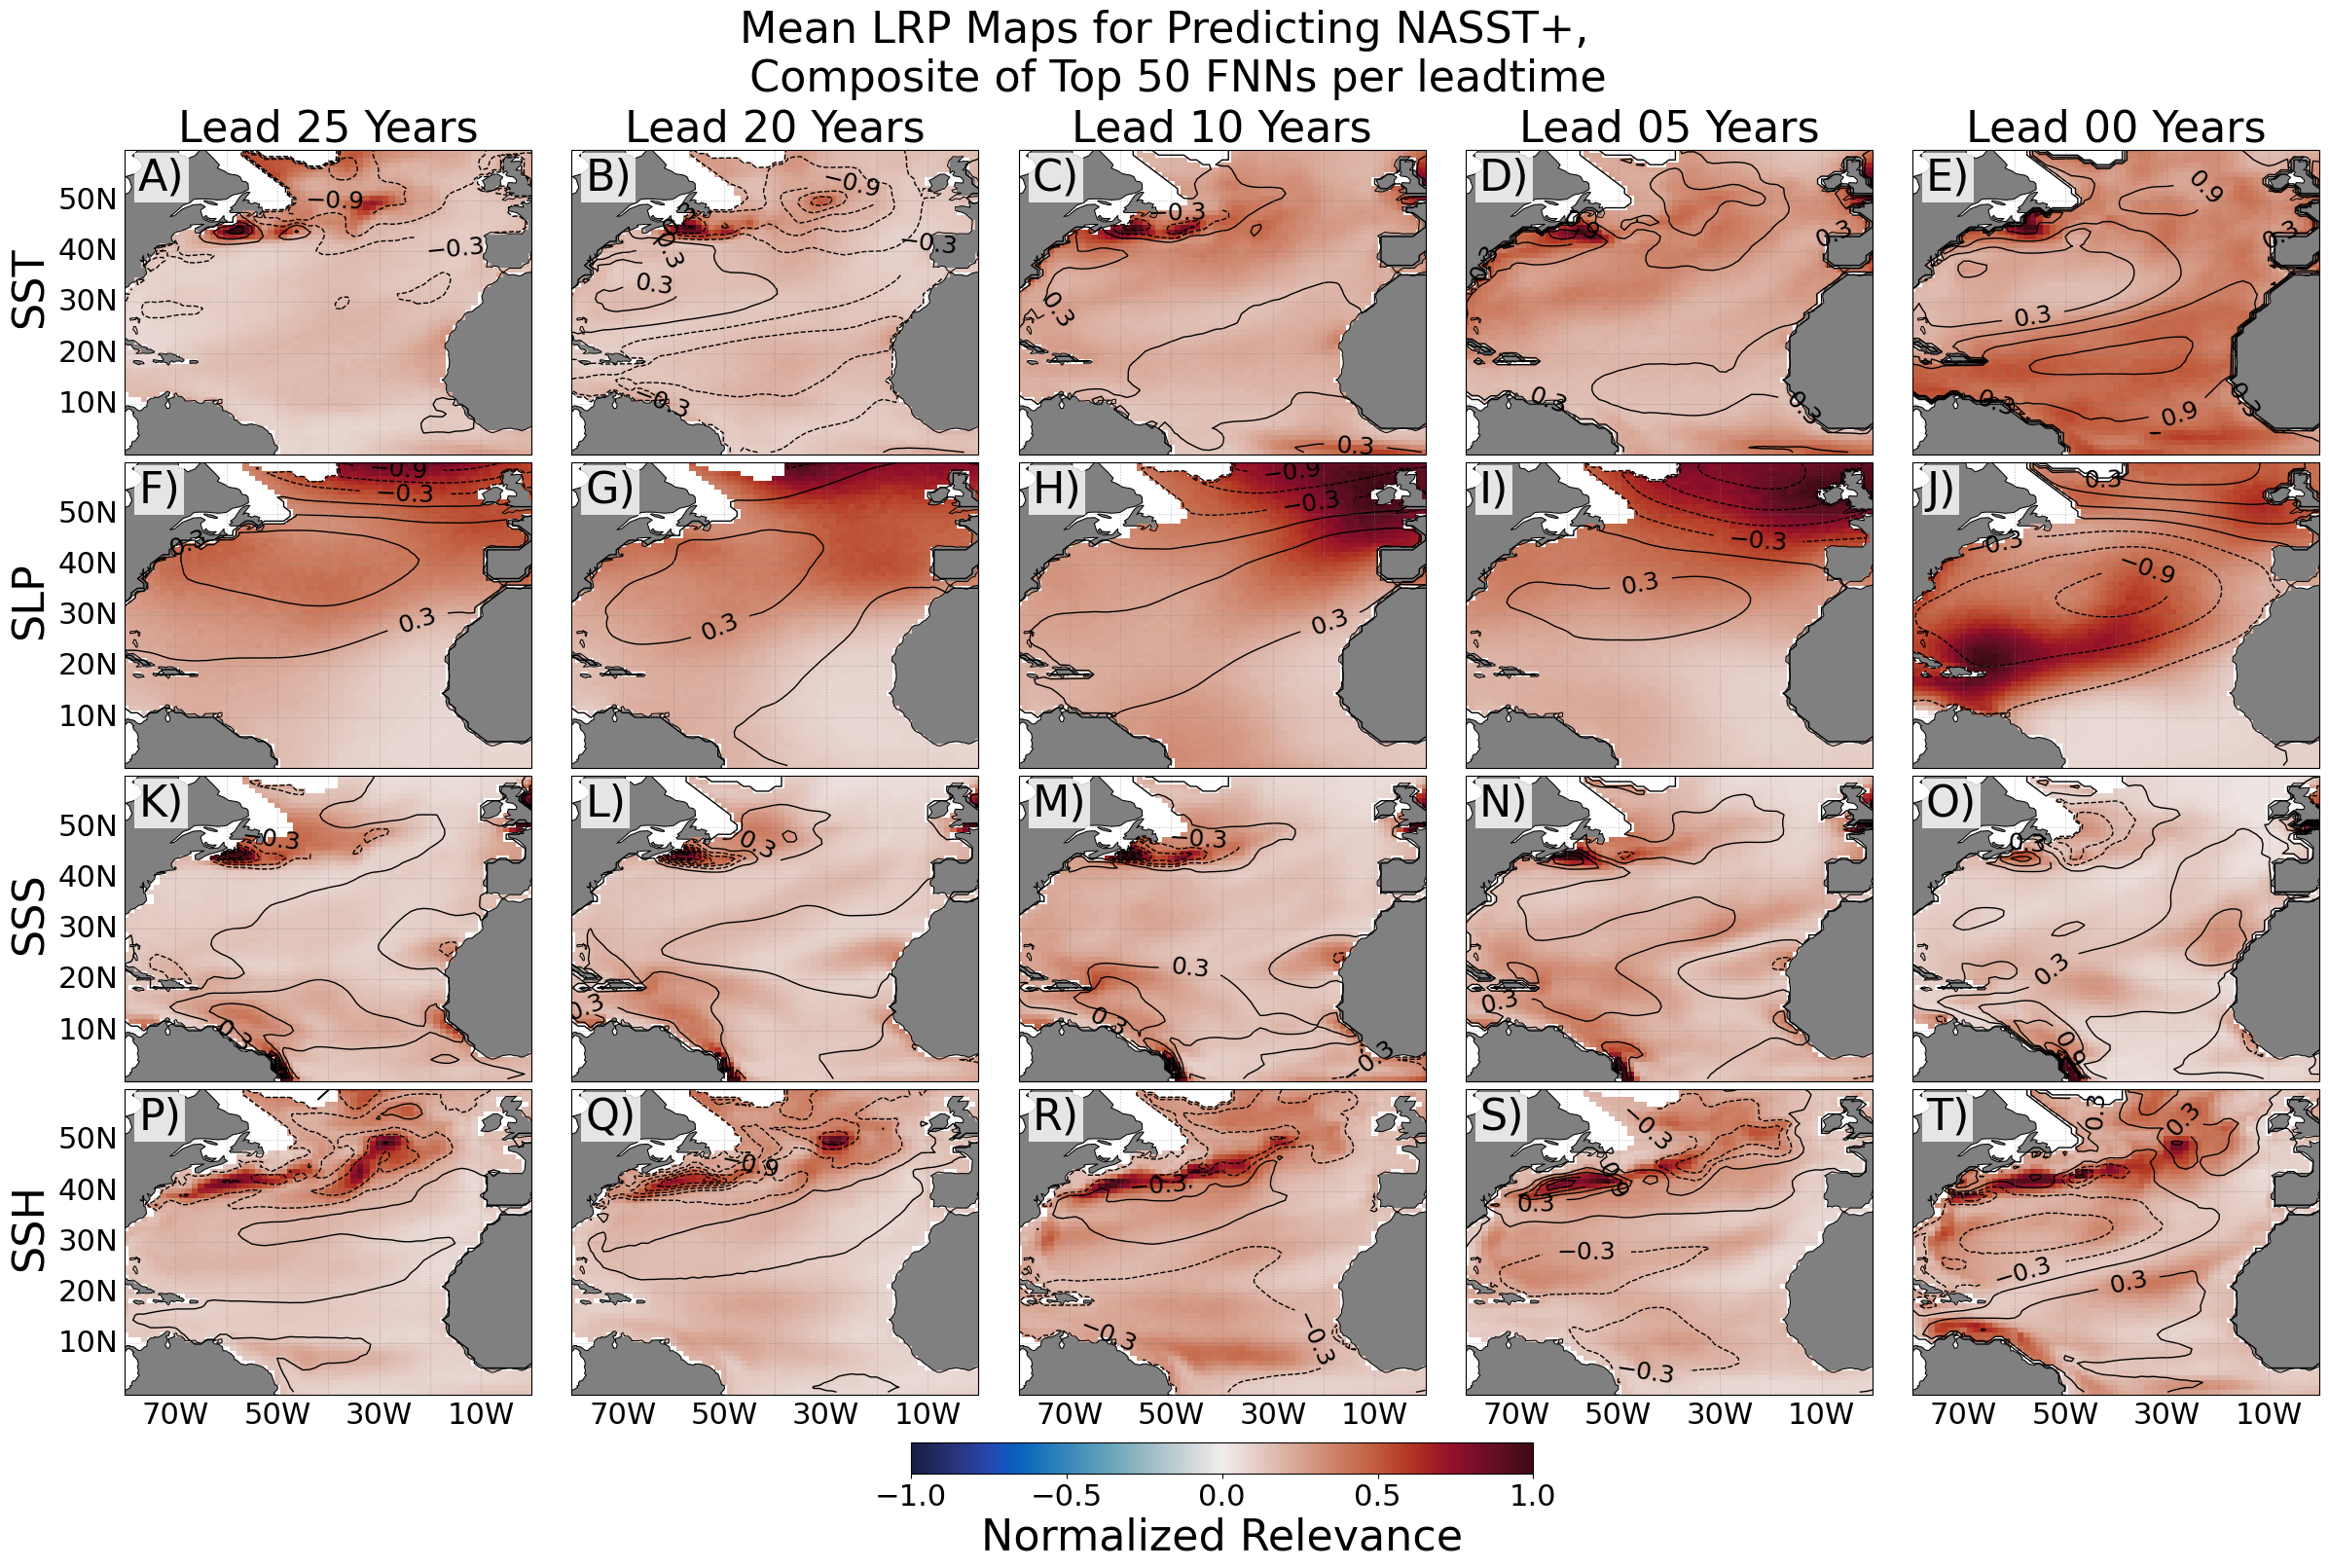

In [43]:
# Make Fig. 3
# -----------

# Select which class you would like to plot
c               = 0 # Class Index, where 0=NASST+, 1=Neutral, 2=NASST-

# Set darkmode
darkmode = False
if darkmode:
    plt.style.use('dark_background')
    dfcol = "w"
    transparent      = True
else:
    plt.style.use('default')
    dfcol = "k"
    transparent      = False

# Indicate which variables to plot
plotvars         = pparams.varnames[:4]
plotorder        = [0,3,2,1] # Indices based on pparams.varnames

# Select which leadtimes to plot, as well as the bounding box
plot_bbox        = [-80,0,0,60]
leadsplot        = [25,20,10,5,0]

# Additional Options
normalize_sample = 2 # 0=None, 1=samplewise, 2=after composite
absval           = False
cmax             = 1
cmin             = 1
clvl             = np.arange(-2.1,2.1,0.3)
no_sp_label      = False
cmap             ='cmo.balance'

# Font Sizes
fsz_title        = 32
fsz_axlbl        = 32
fsz_ticks        = 22
fsz_contourlbl   = 18



ia = 0
fig,axs = plt.subplots(4,5,figsize=(24,16),
                       subplot_kw={'projection':proj},constrained_layout=True)
# Loop for variable
for v,varname in enumerate(plotvars):

    iv = plotorder[v]
    # Loop for leadtime
    for l,lead in enumerate(leadsplot):

        # Get lead index
        id_lead    = list(leads).index(lead)

        if debug:
            print("Lead %02i, idx=%i" % (lead,id_lead))

        # Axis Formatting
        ax = axs[v,l]
        blabel = [0,0,0,0]

        if v == 0:
            ax.set_title("Lead %02i Years" % (leads[id_lead]),fontsize=fsz_title)
        if l == 0:
            blabel[0] = 1
            ax.text(-0.18, 0.55, varnames_plot[iv], va='bottom', ha='center',rotation='vertical',
                    rotation_mode='anchor',transform=ax.transAxes,fontsize=fsz_title)
        if v == (len(plotvars)-1):
            blabel[-1]=1

        ax = viz.add_coast_grid(ax,bbox=plot_bbox,blabels=blabel,fill_color='gray',fontsize=fsz_ticks,ignore_error=True)
        if no_sp_label is False:
            ax = viz.label_sp(ia,ax=ax,fig=fig,alpha=0.8,fontsize=fsz_axlbl)


        # --------- Composite the Relevances and variables --------
        plotrel = rcomps_topN[iv,id_lead,c,:,:]
        if normalize_sample == 2:
            plotrel = plotrel/np.max(np.abs(plotrel))
        plotvar = pcomps[iv][id_lead,c,:,:]

        # Boost SSS values by 1.5
        if varnames_plot[iv] == "SSS":
            plotrel = plotrel*2
        #plotvar = plotvar/np.max(np.abs(plotvar))

        # Set Land Points to Zero
        plotrel[plotrel==0] = np.nan
        plotvar[plotrel==0] = np.nan

        # Do the plotting
        pcm=ax.pcolormesh(lon,lat,plotrel,vmin=-cmin,vmax=cmax,cmap=cmap)
        cl = ax.contour(lon,lat,plotvar,levels=clvl,colors="k",linewidths=1)
        ax.clabel(cl,clvl[::2],fontsize=fsz_contourlbl)
        ia += 1

        # Finish Leadtime Loop (Column)
    # Finish Variable Loop (Row)

# Make Colorbar
cb = fig.colorbar(pcm,ax=axs.flatten(),orientation='horizontal',fraction=0.025,pad=0.01)
cb.set_label("Normalized Relevance",fontsize=fsz_axlbl)
cb.ax.tick_params(labelsize=fsz_ticks)

# Make overall title
if not no_sp_label:
    plt.suptitle("Mean LRP Maps for Predicting %s, \n Composite of Top %02i FNNs per leadtime" % (classes[c],topN,),
                fontsize=fsz_title)
    
# Save Figure
#savename = "%sPredictorComparison_LRP_%s_%s_top%02i_normalize%i_abs%i_%s_Draft2.png" % (figpath,expdir,classes[c],topN,normalize_sample,absval,ge_label_fn)
if darkmode:
    savename = proc.addstrtoext(savename,"_darkmode")
# plt.savefig(savename,dpi=150,bbox_inches="tight",transparent=transparent)


## Figure 4: Class Prediction Count by Year for HadISST

Frequency of each class prediction by year for the forced HadISST NASST Index, using NNs trained with forced CESM1 SST.

Inputs:
 - Predictions computed in \[test_reanalysis.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 - Target from HadISST computed in \[regrid_reanalysis_cesm1.py\], located in "[datpath]/Reanalysis/Regridded/"
 
Contents:
1. User Edits
2. Load in HadISST NASST Index (Target)
3. Load in testing results
4. Bin predictions by year
5. Visualize

*Moved from working script \[viz_LRP_predictor.py\] on 2023.09.13*

In [48]:
# User Edits
# ----------

# HadISST Information
datpath_hadisst    = "%s/Reanalysis/regridded/" % datpath # Path to Target
detrend            = False
dataset_name       = "HadISST"
region_name        = "NAT"
varname            = "SST"

# Set Manual NASST Threshold for classification
manual_threshold   = None # Set to None to automatically detect


In [49]:
# Load in HadISST NASST Index (Target)
# ------------------------------------
re_target  = dl.load_target_reanalysis(dataset_name,region_name,detrend=detrend,datpath=datpath_hadisst)
re_target  = re_target[None,:] # ens x year
nens,ntime = re_target.shape

In [50]:
# Load testing results
# --------------------
savename  = "%s%s/Metrics/Test_Metrics/Test_Metrics_HadISST_%s_accuracy_predictions.npz" % (datpath,expdir,varname)
ld        = np.load(savename,allow_pickle=True)
ld.files

y_predicted_all          = ld['predictions'] 
nleads,nruns,ntime_final = y_predicted_all.shape # [Lead, Run, Year]

In [51]:
# Bin predictions by year
# -----------------------
selected_leads      = leads.copy() #[0,6,12,18,24]
nleads_sel          = len(selected_leads)
count_by_year_leads = np.zeros((ntime_final,nclasses,nleads_sel))

for y in range(ntime_final):
    for ll in range(nleads_sel):
        sel_lead_index = list(leads).index(selected_leads[ll])
        y_pred_year    = y_predicted_all[sel_lead_index,:,y]
        for c in range(3):
            count_by_year_leads[y,c,ll] = (y_pred_year == c).sum()

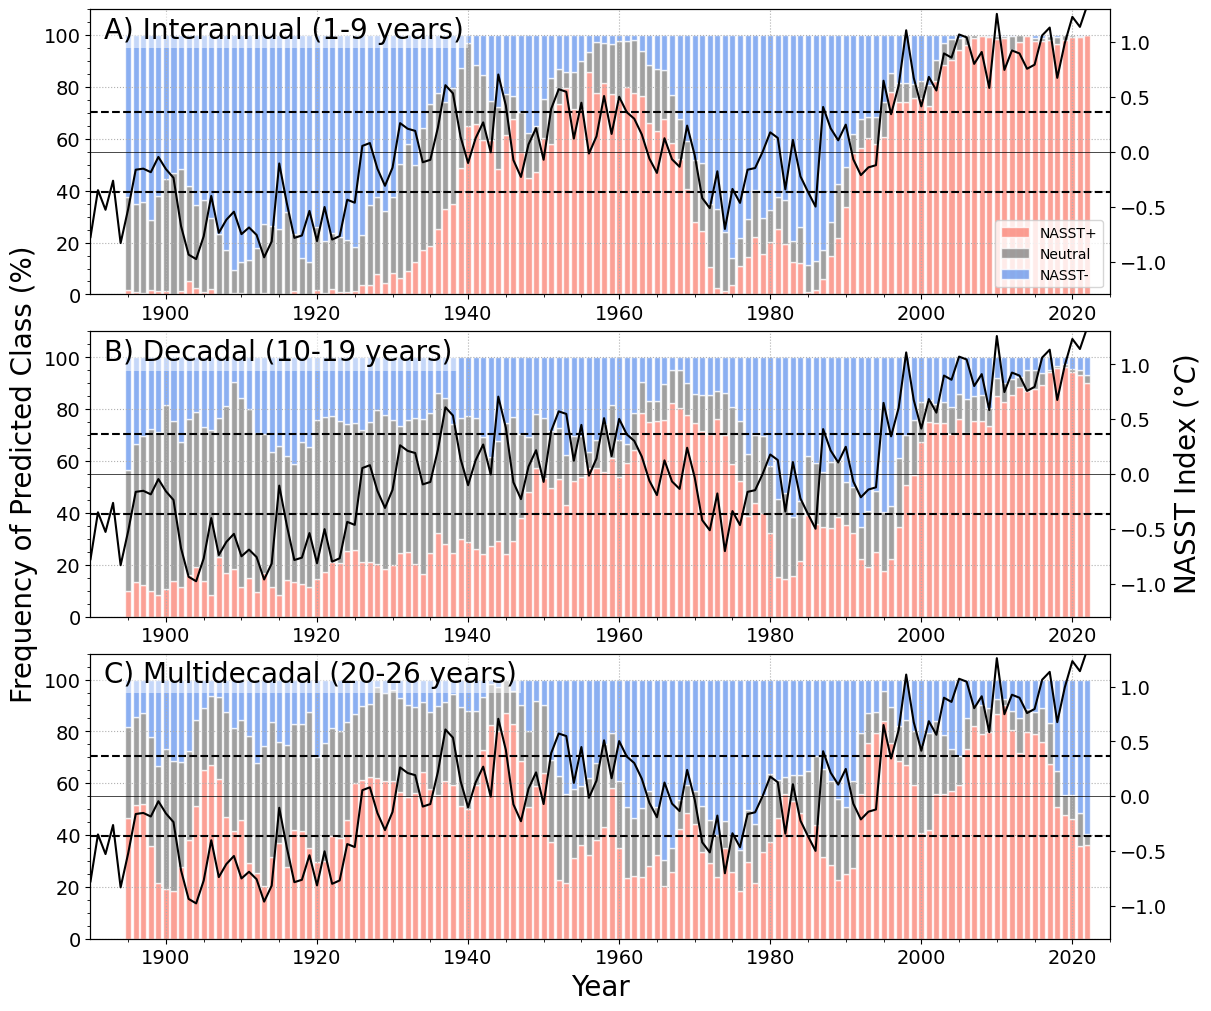

In [52]:
# Make Fig. 4
# -------------
# count_by_year_leads # [year x class x lead]
interann_count      = count_by_year_leads[:,:,np.arange(1,10)].sum(2) # year x class
decadal_count       = count_by_year_leads[:,:,np.arange(10,20)].sum(2)
multidecadal_count  = count_by_year_leads[:,:,np.arange(20,26)].sum(2)

dfcol_r             = "w"
counts_in           = [interann_count,decadal_count,multidecadal_count]
count_labels        = ["Interannual (1-9 years)","Decadal (10-19 years)", "Multidecadal (20-26 years)"]


# Plot Settings
leadmax             = 25
fsz_axlbl           = 20
fsz_ticks           = 14

fig,axs = plt.subplots(3,1,constrained_layout=True,figsize=(12,10))
for ii in range(3):
    ax = axs[ii]

    # Set up timeaxis
    timeaxis      = np.arange(0,len(re_target.squeeze()))
    timeaxis_in   = np.arange(leadmax,re_target.shape[1])
    
    # Plot the counts
    plotcount = counts_in[ii]
    maxcount  = plotcount.sum(-1)
    for c in range(3):
        label = classes[c]
        plotcount = plotcount
        ax.bar(timeaxis_in+1870,plotcount[:,c]/maxcount*100,bottom=plotcount[:,:c].sum(1)/maxcount*100,
               label=label,color=class_colors[c],alpha=0.75,edgecolor=dfcol_r)
    
    # Label and set ticks
    if ii == 0:
        ax.legend(loc='lower right')
    if ii == 1:
        ax.set_ylabel("Frequency of Predicted Class (%)",fontsize=fsz_axlbl)
    ax.minorticks_on()
    ax.grid(True,ls="dotted")
    ax.set_xlim([1890,2025])
    ax.set_ylim([0,110])
    if ii == 2:
        ax.set_xlabel("Year",fontsize=fsz_axlbl)
    
    # Plot NASST Index on Separate Axis
    ax2 = ax.twinx()
    ax2.plot(timeaxis+1870,re_target.squeeze(),color=dfcol,label="HadISST NASST Index")
    if ii == 1:
        ax2.set_ylabel("NASST Index ($\degree C$)",fontsize=fsz_axlbl)
    ax2.set_ylim([-1.3,1.3])
    for th in thresholds_in:
        ax2.axhline([th],color=dfcol,ls="dashed")
    ax2.axhline([0],color=dfcol,ls="solid",lw=0.5)
    ax = viz.label_sp(ii,ax=ax,fig=fig,alpha=0.5,fontsize=fsz_axlbl,labelstyle="%s) "+count_labels[ii])
    
    # Final adjustment of font sizes
    ax.tick_params(labelsize=fsz_ticks)
    ax2.tick_params(labelsize=fsz_ticks)

# figname = "%sHadISST_Prediction_Count_Lead_TimeSplit_%s.png"% (figpath,expdir)
# plt.savefig(figname,dpi=150,bbox_inches="tight",transparent=False)